# Importing Libraries

In [1]:
# BASE
# ---------------------------
import pandas as pd
import numpy as np

import gc

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# Data VISUALIZATION
# ---------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf

# Preprocessing
# ---------------------------
from sklearn.preprocessing import LabelEncoder

# Model
# ---------------------------
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.seasonal import seasonal_decompose
# Evaluation
# ---------------------------
from sklearn.metrics import mean_squared_error


# Reading Data

In [2]:
train =pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
oil=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transactions=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
holidays=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
all_data = [train, transactions, stores, test, oil, holidays]
data_names_in_order = ['train', 'transactions', 'stores', 'test', 'oil', 'holidays']

# Preprocessing

* Time Column Type Conversion
 - time columns should be transferred to datetime type.

In [3]:
# converting time columns' type to pd.datetime
for temp_data in all_data:
    if 'date' in temp_data.columns:
        temp_data.date = pd.to_datetime(temp_data.date)

* Checking time interval
    - We should check what each dataframe time duration is

In [4]:
for c, temp_data in enumerate(all_data):
    if 'date' in temp_data.columns:
        print("Sampling duration starts from", min(temp_data.date), end='  ')
        print(" and is up to", max(temp_data.date), "for ", end='')
        print(data_names_in_order[c])

Sampling duration starts from 2013-01-01 00:00:00   and is up to 2017-08-15 00:00:00 for train
Sampling duration starts from 2013-01-01 00:00:00   and is up to 2017-08-15 00:00:00 for transactions
Sampling duration starts from 2017-08-16 00:00:00   and is up to 2017-08-31 00:00:00 for test
Sampling duration starts from 2013-01-01 00:00:00   and is up to 2017-08-31 00:00:00 for oil
Sampling duration starts from 2012-03-02 00:00:00   and is up to 2017-12-26 00:00:00 for holidays


* Interpolation
    - We should interpolate some data because there are missing values in oil price.

In [5]:
#Oil Interpolation
#Interpolating oil prices because there are some missing values
new_oil = oil.set_index('date').dcoilwtico.resample("D").sum().reset_index()
new_oil["dcoilwtico"] = np.where(new_oil["dcoilwtico"] == 0, np.nan, new_oil["dcoilwtico"])
new_oil["dcoilwtico_interpolated"] = new_oil.dcoilwtico.interpolate()

## Combining dataset

### Train & Test

* Data Concatenation for merging train and test data

In [6]:
train['train'] = 1
test['test'] = 1
data = pd.concat([train,test], axis=0)
data[['train', 'test']] = data[['train', 'test']].fillna(0)
data['date'] = pd.to_datetime(data['date'])

### Oil

* Combining with The Main Dataset

In [7]:
#Adding oil prices to columns
data = data.merge(new_oil[["date", "dcoilwtico_interpolated"]], on='date', how='left')

### Store
    We will include all columns from store dataset in data becuase all of them are usefull

In [8]:
stores.rename(columns={"type":"store_type", "cluster":"store_cluster"}, inplace=True)
data = data.merge(stores, on='store_nbr', how='left')
cols = ['city', 'state', 'store_type', 'store_cluster']
data[cols] = data[cols].astype("category")
#data['store_nbr'] = data['store_nbr'].astype("int")

### Holidays

* Combining Holiday Dataset with The Main Dataset
 

In [9]:
holidays.rename
holidays.rename(columns={"type":"holiday_type", "locale":"holiday_locale", "locale_name":"off_locale_name"}, inplace=True)
# adding a dummy column in order to transfer this new boolean column when merging data and holidays
holidays['is_holiday'] = True

* Constant Holidays Which Are Sundays

In [10]:
#Normal Sunday Holidays
# Sunday becomes 7 in weekday
sundays_hol = data.date.dt.weekday == 6

* Other Events and Hoildays

In [11]:
# hoilday should not be transferred to another data, nor be workday so that we include this condition in all below conditions
# condition = (holidays.holiday_type != "Work Day") & (holidays.transferred == False)
#Also we should remove duplicate rows which have emerged by pd.merge

holidays["date"] = pd.to_datetime(holidays["date"])

# National Holidays
national_hols = holidays[(holidays.holiday_type != "Work Day") & (holidays.transferred == False) & (holidays.holiday_locale == "National")]
national_hols = data.merge(national_hols[["date", "is_holiday"]], how="left", on="date")
national_hols = national_hols[national_hols.id<len(data)].drop_duplicates(subset=['id'])
national_hols['is_holiday'] = national_hols['is_holiday'].fillna(False)


#Local(city) holidays
city_hols = holidays[(holidays.holiday_type != "Work Day") & (holidays.transferred == False) & (holidays.holiday_locale == "Local")]
city_hols = data.merge(city_hols.rename(columns={"off_locale_name":"city"})[["date", "is_holiday", "city"]], how="left", on=["date", "city"])
city_hols = city_hols[city_hols.id<len(data)].drop_duplicates(subset=['id'])
city_hols['is_holiday'] = city_hols['is_holiday'].fillna(False)


#Regional(state) holidays
state_hols = holidays[(holidays.holiday_type != "Work Day") & (holidays.transferred == False) & (holidays.holiday_locale == "Local")]
state_hols = data.merge(state_hols.rename(columns={"off_locale_name":"state"})[["date", "is_holiday", "state"]], how="left", on=["date", "state"])
state_hols = state_hols[state_hols.id<len(data)].drop_duplicates(subset=['id'])
state_hols['is_holiday'] = state_hols['is_holiday'].fillna(False)


all_hols = sundays_hol.values | national_hols['is_holiday'].values  | city_hols['is_holiday'].values  | state_hols['is_holiday'].values
data['is_holiday'] = all_hols.astype("bool")

/tmp/ipykernel_18/639165446.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  national_hols['is_holiday'] = national_hols['is_holiday'].fillna(False)
/tmp/ipykernel_18/639165446.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  city_hols['is_holiday'] = city_hols['is_holiday'].fillna(False)
/tmp/ipykernel_18/639165446.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('f

# Feature Engineering

## Trend
    We calculate average daily sales by moving average for all products and then find the trend by regression

Text(0.5, 1.0, 'detrended data')

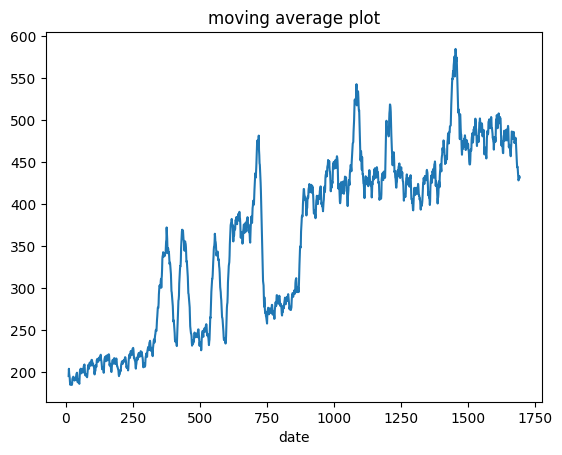

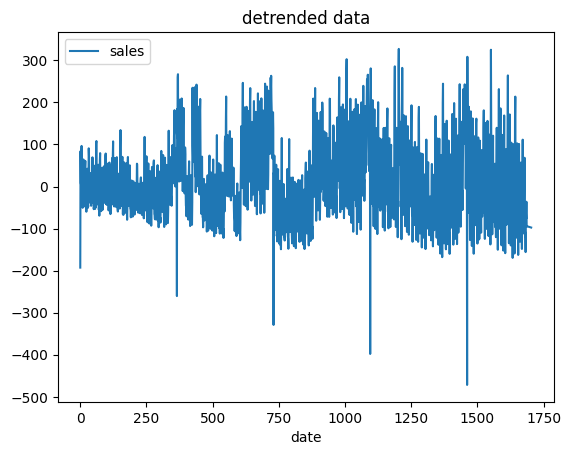

In [12]:
#Calculating average daily sales 
average_sales = data.groupby('date').sales.mean().reset_index()
average_sales = average_sales.set_index("date").resample("D").sum().reset_index()
average_sales["sales"] = np.where(average_sales["sales"] == 0, np.nan, average_sales["sales"])
average_sales["sales"] = average_sales["sales"].interpolate()

#Calculating moving average (MA)
average_sales = data.groupby('date').sales.mean().reset_index()
average_sales = average_sales.set_index("date").resample("D").sum().reset_index()
average_sales["sales"] = np.where(average_sales["sales"] == 0, np.nan, average_sales["sales"])
average_sales["sales"] = average_sales["sales"].interpolate()
date_range_complete = average_sales.date.copy()
average_sales.date = np.arange(len(average_sales))
average_sales = average_sales.set_index('date')
window_size = 20
moving_average_sales = average_sales.sales.rolling(window=window_size, center = True).mean()
moving_average_sales.plot()
plt.title('moving average plot')

# Fitting Model
trend_model = LinearRegression()
date_range = np.array(range(len(moving_average_sales))).reshape(-1, 1)[window_size:-window_size]
moving_average_sales = moving_average_sales[window_size:-window_size]
trend_model.fit(date_range, moving_average_sales)
trend_predictions = pd.DataFrame({"sales":trend_model.predict(np.array(range(len(average_sales))).reshape(-1, 1))})
trend_predictions.index = pd.Index(range(len(average_sales)))
detrended = average_sales - trend_predictions
detrended.plot()

plt.title('detrended data')

Now that we have calculated the sales trend we add to the data as a new feature

In [13]:
time_range = pd.date_range(start=data.date.iloc[0], end=data.date.iloc[-1])
time_arange = np.arange(len(time_range))
predicted = trend_model.predict(time_arange.reshape(-1, 1))
trend_df = pd.DataFrame({"date":list(time_range), "trend":list(predicted)})
data = data.merge(trend_df, how='left', on='date')

## Seasonality

### Periodogram
I used fourier transform to get the seasonality of the data. I used fft plot of the data to check the peak amplitudes of different frequencies and include them in the data time features.

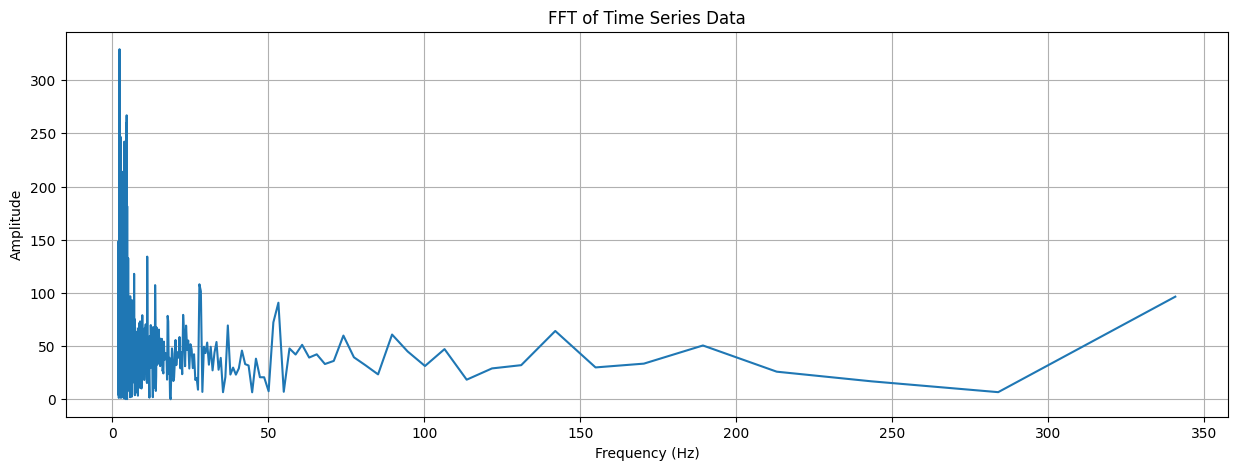

In [14]:
# Compute FFT
y = detrended
fft_result = np.fft.fft(y)

# Frequency axis
sampling_frequency = 1   # Sampling frequency is day by day
freq = np.fft.fftfreq(len(y), d=1/sampling_frequency)

# converting frequency too time
positive_freq_mask = freq > 0
time = 1/(freq+1e-6)[positive_freq_mask]
amplitudes = np.abs(fft_result)[positive_freq_mask]

#including only one year intereval
time_mask = time < 370
time = time[time_mask]
amplitudes = amplitudes[time_mask]

# Plot FFT
plt.figure(figsize=(15, 5))
plt.plot(time, amplitudes)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of Time Series Data')
plt.grid(True)
plt.show()

As you can see there are some local peaks in amplitude that shows strong seasonality relation between data samples. This can also be proven by lag data correlation values. Thus we can only rely on adding some routine time features as well as lag data to cover both seasonality and lags.
Note that we have to also take a look at short time periods to consider less than 30 days frequencies. The plot below shows this.

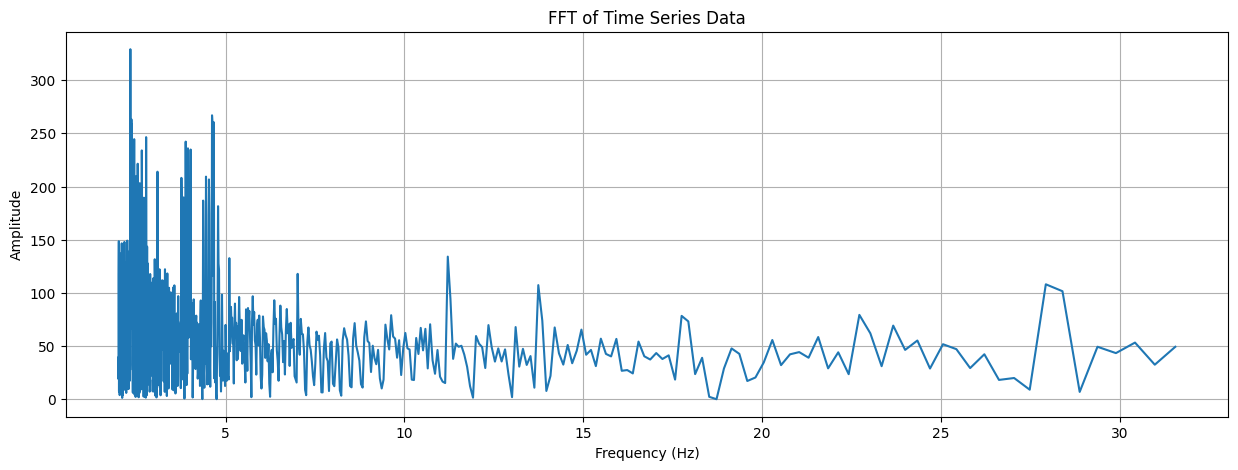

In [15]:
#including only one year intereval
time_mask = time < 32
time = time[time_mask]
amplitudes = amplitudes[time_mask]

# Plot FFT
plt.figure(figsize=(15, 5))
plt.plot(time, amplitudes)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of Time Series Data')
plt.grid(True)
plt.show()

As you see there are pretty considerable amplitude peaks in multiplies of 7 which is a week duration. So it is better to include these numbers when including lag values.

### Adding wages day

* Finding the last day of each month
  This helps to find on which day the wage is paid because wages are paid on 15 and last day of the month

In [16]:
temp = data.copy()
temp['day'] = train.date.dt.day
temp['month'] = train.date.dt.month
x = temp.groupby(temp.month).day.max()

Including wageday and the day after it to the data

In [17]:
#train.date.dt.day
# find out if it wage day. Wages are paid on the last day and 15th of each month and also the day after wage day is important
# wageday
a = (data.date.dt.day == 15) | (data.date.dt.day == 31)
b = data.date.dt.month.isin([4, 6, 9, 11]) & data.date.dt.day == 30
c = data.date.dt.month.isin([2]) & data.date.dt.day == 29
data['iswageday'] = a | b | c

#the day after wageday
a = (data.date.dt.day == 16) | (data.date.dt.day == 1)
data['day_after_wageday'] = a 

data[['iswageday', 'day_after_wageday']] = data[['iswageday', 'day_after_wageday']]

### Date Features
    we add these features in to extract some important information to cover a part of the data seasonality

In [18]:
data['dayofweek'] = data.date.dt.weekday + 1 # plus one  to avoid having zero value 
data['month'] = data.date.dt.month
data['dayofyear'] = data.date.dt.dayofyear
data['dayofmonth'] = data.date.dt.day
data['year'] = data.date.dt.year
data['weekofmonth'] = ((data.date.dt.day-1) // 7) + 1
data['season'] = np.where(data.date.dt.month.isin([1,2,12]), 0, 1)
data['season'] = np.where(data.date.dt.month.isin([6,7,8]), 2, data['season'])
data['season'] = np.where(data.date.dt.month.isin([9,10,11]), 3, data['season'])
date_features = ['year', 'season', 'month', 'dayofmonth', 'dayofyear', 'dayofweek', 'weekofmonth']
data[date_features] = data[date_features].astype("int")

* Train Columns Features

In [19]:
# Converting Onpromotion as a boolean column to tha data
data['is_onpromotion'] = data['onpromotion'] > 0

* ACF & PCF

In [20]:
fourier = CalendarFourier(freq="A", order=500)
dates = pd.date_range(start='2013-01-01', end='2017-08-15', freq='D')
dp = DeterministicProcess(
    index=dates,
    constant=True,               # dummy feature for bias (y-intercept)
    #order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)
Z = dp.in_sample()
# plt.figure(figsize=(12, 6))
#plt.plot(detrended.index, detrended.values)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


### Lags

#### ACF & PACF

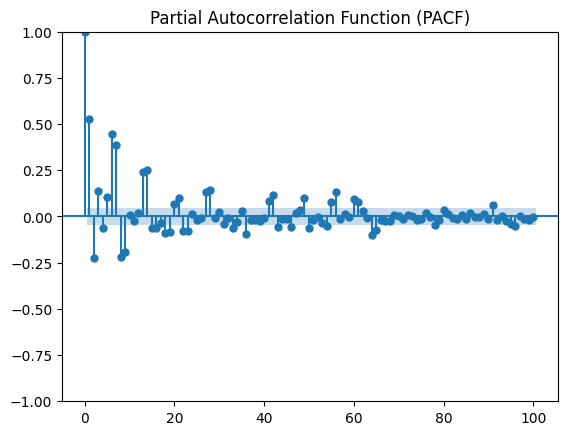

In [21]:
plot_pacf(detrended, lags=100, title='Partial Autocorrelation Function (PACF)')
plt.show()

#### Lag plots

In [22]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

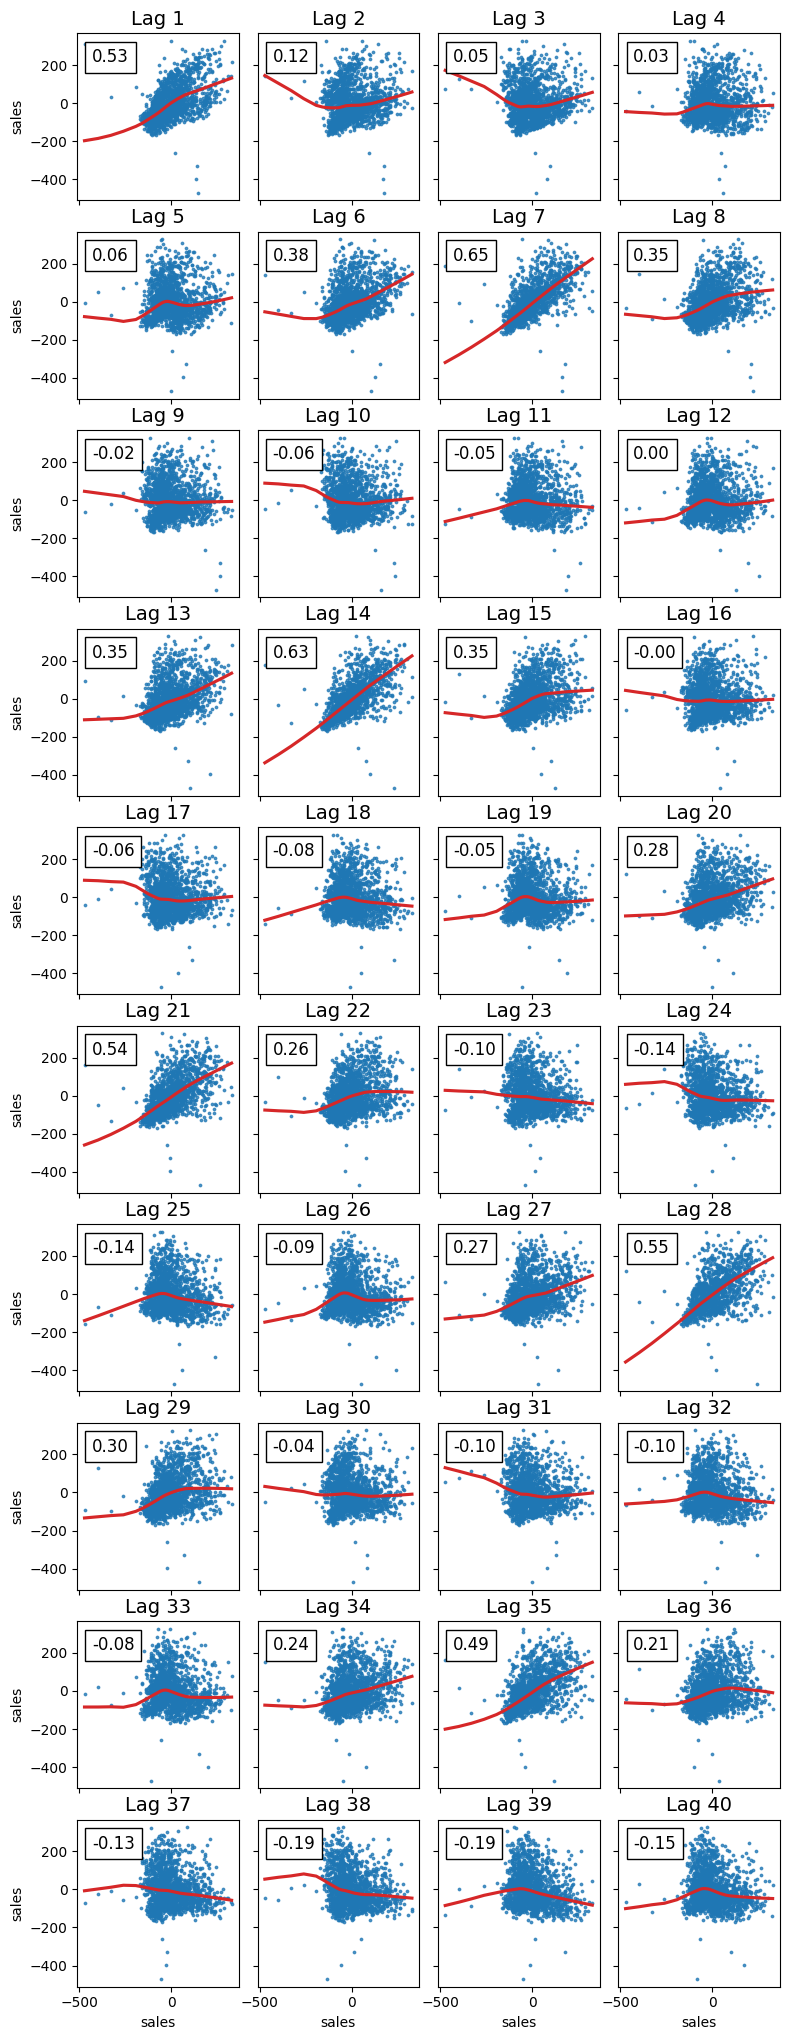

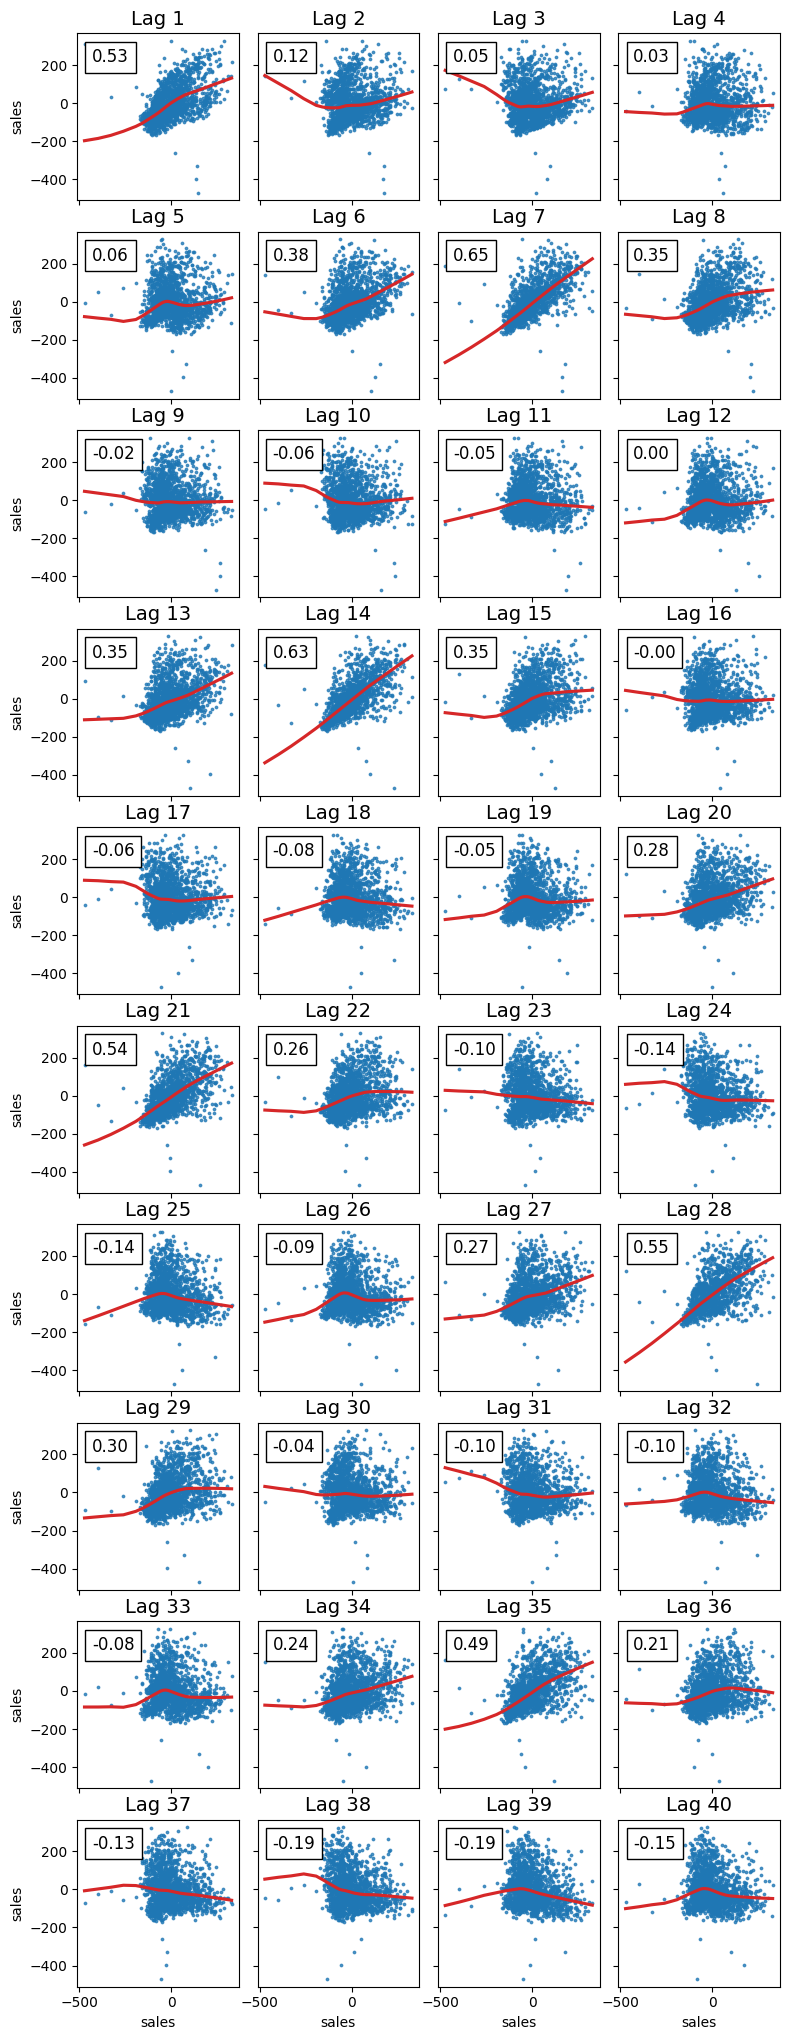

In [23]:
plot_lags(detrended.sales, lags = 370, nrows = 10, ncols = 4)

* Adding Lag Features
    - In the code below we add the listed number lags as features to the main data. Note that here we dismiss lag numbers below 15 cause we are not gonna have those values for the prediction time range

In [24]:
def add_lag_features(inp_data, lags):
    out_data = data.copy()
    for lag_number in lags:
        out_data["lag_"+ str(lag_number)] = lagged = inp_data.groupby(["family", "store_nbr"]).shift(lag_number).reset_index().sales
    return out_data
    
lag_numbers = [21, 27, 28, 35, 41, 49, 56, 63, 70, 77, 80]
lag_numbers_2 = [91, 108, 114, 126, 136, 140, 158, 182, 196, 259, 287, 322, 336, 364]
lagged_data = add_lag_features(data, lag_numbers + lag_numbers_2)

* Laggs Correlation
    - In the code below we calculate the correlation of lag values with each other as well as sales data to check how much informative they will be for prediction

In [25]:
lagged_data[["sales"]+lagged_data.columns[lagged_data.columns.str.startswith("lag_")].tolist()].corr()

,sales,lag_21,lag_27,lag_28,lag_35,lag_41,lag_49,lag_56,lag_63,lag_70,...,lag_136,lag_140,lag_158,lag_182,lag_196,lag_259,lag_287,lag_322,lag_336,lag_364
sales,1.000000,0.915722,0.878520,0.912003,0.903731,0.871547,0.901670,0.901710,0.903242,0.891662,...,0.804537,0.858266,0.804000,0.862299,0.855177,0.858414,0.848998,0.841324,0.845441,0.846241
lag_21,0.915722,1.000000,0.901275,0.935911,0.928046,0.881447,0.911850,0.903537,0.902734,0.901485,...,0.809312,0.872159,0.807654,0.853962,0.856957,0.855167,0.854899,0.844225,0.841111,0.835316
lag_27,0.878520,0.901275,1.000000,0.918704,0.894097,0.927801,0.876955,0.876093,0.867238,0.867564,...,0.813706,0.835265,0.822189,0.825329,0.825911,0.822723,0.827240,0.812965,0.810791,0.813304
lag_28,0.912003,0.935911,0.918704,1.000000,0.935726,0.890849,0.915203,0.911459,0.903147,0.902316,...,0.812308,0.867122,0.807806,0.857123,0.856668,0.853428,0.858188,0.843225,0.842270,0.844804
lag_35,0.903731,0.928046,0.894097,0.935726,1.000000,0.900853,0.927510,0.914872,0.911002,0.902818,...,0.812041,0.872168,0.816037,0.853794,0.852996,0.850110,0.854460,0.848149,0.844828,0.839883
lag_41,0.871547,0.881447,0.927801,0.890849,0.900853,1.000000,0.893598,0.888598,0.876304,0.875319,...,0.817386,0.840373,0.827767,0.823905,0.823960,0.818280,0.829757,0.818612,0.813708,0.810122
lag_49,0.901670,0.911850,0.876955,0.915203,0.927510,0.893598,1.000000,0.935041,0.926946,0.914210,...,0.817216,0.881086,0.812775,0.859165,0.852814,0.853326,0.854115,0.859570,0.848960,0.839220
lag_56,0.901710,0.903537,0.876093,0.911459,0.914872,0.888598,0.935041,1.000000,0.934814,0.926658,...,0.820295,0.878659,0.813636,0.862231,0.855334,0.850608,0.852507,0.853485,0.849675,0.840429
lag_63,0.903242,0.902734,0.867238,0.903147,0.911002,0.876304,0.926946,0.934814,1.000000,0.934635,...,0.824306,0.886637,0.816545,0.868984,0.858178,0.853560,0.849052,0.856835,0.860232,0.842690
lag_70,0.891662,0.901485,0.867564,0.902316,0.902818,0.875319,0.914210,0.926658,0.934635,1.000000,...,0.827965,0.888468,0.820105,0.864061,0.861225,0.853410,0.848933,0.853200,0.854372,0.842194


# Model

## Training

In [26]:
final_data = lagged_data.copy()
final_data = final_data[final_data.train == 1]
#we should drop the sales column and set it as y
final_data = final_data.drop(columns=['sales'], axis=1)

* One Hot Encoding 
    - We do this to make the data suitable for xgb module

In [27]:
#find categorical features 
categorical_features = ['family', 'dayofweek','month','year','weekofmonth','season',
                        'city','state','store_type','store_cluster']
   
# One-hot encode the specified columns
final_data = pd.get_dummies(final_data, columns=categorical_features)

In [28]:
label_encoder = LabelEncoder()
#final_data['family'] = label_encoder.fit_transform(final_data['family'])
final_data['daterange'] = np.arange(len(final_data['date']))
final_data = final_data.drop(columns=['date'])
y = train.sales
data_train, data_test, y_train, y_test = train_test_split(final_data, y, test_size=0.2, random_state=42)

In [29]:
params = {'objective':'reg:squarederror',  'eval_metric':'rmse'}

# Convert training data to DMatrix
dtrain = xgb.DMatrix(data_train, label=y_train)

# Train the dataGBoost model
num_rounds = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_rounds)

## Evaluation

In [30]:
def rmsle(y_true, y_pred):
    epsilon = 1e-6
    """
    Calculate Root Mean Squared Logarithmic Error (RMSLE)
    """
    assert len(y_true) == len(y_pred)
    a = np.log1p(y_pred + epsilon)
    b = np.log1p(y_true + epsilon)
    squared_errors = ( a - b ) ** 2
    mean_squared_log_error = np.mean(squared_errors)
    rmsle = np.sqrt(mean_squared_log_error)
    return rmsle

In [31]:
# Convert testing data to DMatrix
dtest = xgb.DMatrix(data_test)

# Make predictions on the testing data
predictions = bst.predict(dtest)

# Evaluate model performance
from sklearn.metrics import mean_squared_error

y_test_trended = y_test 
predictions_trended = predictions 
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print("Root Mean Squared Error:", rmse)

rmsle_score = rmsle(y_test, predictions)
print("RMSLE:", rmsle_score)

Root Mean Squared Error: 258.78211593826916
RMSLE: 1.1414313020116504


/tmp/ipykernel_18/1337793286.py:7: RuntimeWarning: invalid value encountered in log1p
  a = np.log1p(y_pred + epsilon)


### Test data Evaluation

* Test Preprocesing
    - Here we do the exact preprocessing which we did for training dataset

In [32]:
test_data = lagged_data[lagged_data.test == 1].copy()
test_data = test_data.drop(columns=['sales'], axis=1)
test_data = pd.get_dummies(test_data, columns=categorical_features)
test_data['daterange'] = np.arange(len(test_data['date']))
test_data = test_data.drop(columns=['date'])

train_columns = final_data.columns.tolist()
test_columns = test_data.columns.tolist()
test_data[list(set(train_columns)-set(test_columns))] = False
train_columns = final_data.columns
test_data_reordered = test_data[train_columns]

# Submission File

In [33]:
# Convert testing data to DMatrix
dtest = xgb.DMatrix(test_data_reordered)
predictions = bst.predict(dtest)
# There should not be any negative values. we replace negative ones with zero cause the most probably show no sales
predictions[predictions < 0] = 0
submission = pd.DataFrame({"id":test_data_reordered.id.values, "sales":predictions})
submission.to_csv('submission.csv', index = False)